In [1]:
"""
LCgenerationDE.py

Created on Fri Nov  7 16:18:50 2014

Original Author: Sam Connolly
Modified by: Ryne Dingler

Python version of the light curve simulation algorithm from 
Emmanoulopoulos et al., 2013, Monthly Notices of the Royal 
Astronomical Society, 433, 907.

Uses 'Lightcurve' objects to allow easy interactive use and 
easy plotting. 

The PSD and PDF can be supplied, or a given model can be fitted 
Both best fitting models from fits to data and theoretical models can be used.

requires:
    numpy, pylab, scipy, pickle

"""

import os
import time as time
import warnings
warnings.filterwarnings('ignore')

import pylab as plt
from astropy.io import fits

import numpy as np
import numpy.fft as ft
import numpy.random as rnd

import scipy.integrate as itg
import scipy.stats as st
from scipy.stats import rv_continuous
import scipy.optimize as op
from scipy.optimize import curve_fit
import scipy.special as sp
from scipy.special import gamma as Γ


######################################################################################################################
 

#__all__ = ['Mixture_Dist', 'BendingPL', 'RandAnyDist', 'Min_PDF','OptBins',
#            'PSD_Prob','SD_estimate','TimmerKoenig','EmmanLC','Lightcurve',
#            'Comparison_Plots','Load_Lightcurve','Simulate_TK_Lightcurve',
#            'Simulate_DE_Lightcurve']


# ------ Distribution Functions ------------------------------------------------

class Mixture_Dist(object):
   
    '''
    Create a mixture distribution using a weighted combination of the functions 
    in the array 'funcs'. The resultant object can both calculate a value
    for the function and be randomly sampled.
    
    inputs:
        functions (array of functions) 
            - list of all of the functions to mix
        n_args (2-D array) 
            - numerical array of the parameters of each function
        frozen (list, [int,int], optional) 
            - list of the indices of parameters which which should be frozen
              in the resultant function and their values, e.g. [[1,0.5]]
              will freeze the parameter at position 1 to be 0.5
        force_scipy (bool, optional)
            - If the code will not recognise scipy distributions (or is giving
              parsing errors), this flag will force it to do so. Can occur
              due to old scipy versions.
    functions:
        Sample(params,length) 
            - produce a random sample of length 'length' from the function for 
              a given set of paramaters.
        Value(x, params)
            - calculate the value of the function at the value(s) x, for
              the paramters given.
    '''
    
    def __init__(self,functions,n_args,frozen=None, force_scipy=False):
        self.functions = functions
        self.n_args = n_args  
        self.frozen = frozen  
        self.__name__ = 'Mixture_Dist'
        self.default  = False

        if functions[0].__module__ == 'scipy.stats._continuous_distns' or \
                force_scipy == True:
            self.scipy = True
        else:
            self.scipy = False
        
    def Sample(self,params,length=1):
        '''
        Use inverse transform sampling to randomly sample a mixture of any set
        of scipy contiunous (random variate) distributions.
        
        inputs:
            params (array)          - list of free parameters in each function
                                         followed by the weights - e.g.:
                                         [f1_p1,f1_p2,f1_p3,f2_p1,f2_p2,f2_p3,w1,w2]
            length (int)            - Length of the random sample
        outputs:
            sample (array, float)   - The random sample
        '''
        
        if self.scipy == True:        
            cumWeights = np.cumsum(params[-len(self.functions):])
            # random sample for function choice
            mix    = np.random.random(size=length)*cumWeights[-1]  

            sample = np.array([])
            
            args = []        
            
            if self.frozen:
                n = self.n_args[0] - len(self.frozen[0][0])
                par = params[:n]
                if len(self.frozen[0]) > 0:
                    for f in range(len(self.frozen[0][0])):
                        par = np.insert(par,self.frozen[0][0][f]-1,
                                                           self.frozen[0][1][f])
            else:
                n = self.n_args[0]
                par = params[:n]    
                
            args.append(par)
            
            for i in range(1,len(self.functions)):
                if self.frozen:
                    if len(self.frozen[i]) > 0:
                        n_next = n + self.n_args[i] - len(self.frozen[i][0])
                        par = params[n:n_next]
                        if len(self.frozen[i]) > 0:
                                for f in range(len(self.frozen[i][0])):
                                    par = np.insert(par,
                                    self.frozen[i][0][f]-1,self.frozen[i][1][f])
                        else:
                            n_next = n+self.n_args[i]
                            par = params[n:n_next] 
                    else:
                        n_next = n+self.n_args[i]
                        par = params[n:n_next]
                args.append(par)
                    
            # cycle through each distribution according to probability weights
            for i in range(len(self.functions)): 
                if i > 0:
                    
                    sample = np.append(sample, self.functions[i].rvs(args[i][0],
                                    loc=args[i][1], scale=args[i][2],
                    size=len(np.where((mix>cumWeights[i-1])*
                                                    (mix<=cumWeights[i]))[0]))) 
                    
                else:
                    sample = np.append(sample, self.functions[i].rvs(args[i][0],
                                 loc=args[i][1],scale=args[i][2],
                                   size=len(np.where((mix<=cumWeights[i]))[0])))
                    
            # randomly mix sample
            np.random.shuffle(sample)
            
            # return single values as floats, not arrays
            if len(sample) == 1:
                sample = sample[0]

            return sample 
    
    def Value(self,x,params):
        '''
        Returns value or array of values from mixture distribution function.
        
        inputs:
            x (array or float) - numerical array to which the mixture function 
                                 will be applied
            params (array)     - list of free parameters in each function
                                     followed by the weights - e.g.:
                                     [f1_p1,f1_p2,f1_p3,f2_p1,f2_p2,f2_p3,w1,w2]
        outputs:
            data (array)        - output data array
        '''

        if self.scipy == True:   
            functions = []
            for f in self.functions:
                functions.append(f.pdf)
                
        else:
            functions = self.functions
        
        
        n = self.n_args[0]
        
        if self.frozen:
            n = self.n_args[0] - len(self.frozen[0][0])
            par = params[:n]
            if len(self.frozen[0]) > 0:
                for f in range(len(self.frozen[0][0])):
                    par = np.insert(par,self.frozen[0][0][f]-1,\
                                    self.frozen[0][1][f])
        else:
            n = self.n_args[0]
            par = params[:n]

        data = np.array(functions[0](x,*par))*params[-len(functions)]        
        for i in range(1,len(functions)):
            
            if self.frozen:
                if len(self.frozen[i]) > 0:
                    n_next = n + self.n_args[i] - len(self.frozen[i][0])
                    par = params[n:n_next]
                    if len(self.frozen[i]) > 0:
                        for f in range(len(self.frozen[i][0])):
                            par = np.insert(par,self.frozen[i][0][f]-1,\
                                            self.frozen[i][1][f])
                else:
                    n_next = n+self.n_args[i]
                    par = params[n:n_next] 
            else:
                n_next = n+self.n_args[i]
                par = params[n:n_next]            
            
            
            data += np.array(functions[i](x,*par))*params[-len(functions)+i] 
            n = n_next
        data /= np.sum(params[-len(functions):])
        return data
    
################################################################################
def gaussian(x, A, μ, σ):
    '''
    Gaussian distribution.
    
    inputs:
        A (float)    - normalisation
        μ (float)    - mean
        σ (float)    - standard deviation
    '''
    
    return A * np.exp(-(x - μ)**2 / (2*σ**2))

def lognormal(x, A, μ, σ):
    '''
    lognormal distribution.
    
    inputs:
        A (float)    - normalisation
        μ (float)    - mean
        σ (float)    - standard deviation
    '''
    return 1/x * gaussian(np.log(x), A, μ, σ)


def bimodal(x, p, A, μ1, σ1, B, μ2, σ2):
    '''
    Bimodal Gaussian distribution.
    
    inputs:
        p (float)     - initial guess of fractional contribution due to 
                        one distribution
        A (float)     - 1st normalisation
        μ1 (float)    - 1st mean
        σ1 (float)    - 1st standard deviation
        B (float)     - 2nd normalisation
        μ2 (float)    - 2nd mean
        σ2 (float)    - 2nd standard deviation
        
    '''
    ϕ = 0.5 + np.arctan(p)/np.pi ## keeps frctional values between 0 and 1
    return ϕ * gaussian(x, A, μ1, σ1) + (1-ϕ) * gaussian(x, B, μ2,σ2)



  
    ################################################################################

def PLaw(v,A,alpha,c):
    '''
    Bending power law function - returns power at each value of v, 
    where v is an array (e.g. of frequencies)
    
    inputs:
        v (array)       - input values
        A (float)       - normalisation
        v_0 (float)     - normalisation frequency (Uttley et al. 2002)
        alpha (float)   - frequency index
        c (float)       - intercept/offset
    output:
        out (array)     - output powers
    '''
    out = A * v**-alpha + c
    
    return out

def BrokenPL(v,A,v_break,a_low,a_high,c):
    '''
    Broken power law function - returns power at each value of v, 
    where v is an array (e.g. of frequencies)
    as defined in  P. Uttley, I. M. McHardy and I. E. Papadakis 2002
    
    inputs:
        v (array)       - input values
        A (float)       - normalisation 
        v_break (float) - break frequency
        a_low (float)   - low frequency index
        a_high float)   - high frequency index
        c (float)       - intercept/offset
    output:
        out (array)     - output powers
    '''
    broken = np.piecewise(v,[v<v_break,v>v_break],[lambda v:(v/v_break)**-a_low, lambda v:(v/v_break)**-a_high])
    out = A*broken + c
    
    return out

def PL_Lorentzian(v,A,lrtz_sigma,lrtz_mu,alpha,c):
    '''
    Power law function with lorentzian component - returns power at each value of v, 
    where v is an array (e.g. of frequencies)
    
    inputs:
        v (array)           - input values
        A (float)           - normalisation 
        lrtz_sigma (float)  - spread
        lrtz_mu (float)     - center
        alpha (float)       - high frequency index
        c (float)           - intercept/offset
    output:
        out (array)         - output powers
    '''
    plaw = v**-alpha
    numer = 0.5*lrtz_sigma
    denom = (v-lrtz_mu)**2 + (0.5*lrtz_sigma)**2
    lorentz = (numer/denom)/np.pi
    out = A*(plaw+lorentz)+ c
    
    return out


def BendingPL(v,A,v_bend,a_low,a_high,c):
    '''
    Bending power law function - returns power at each value of v, 
    where v is an array (e.g. of frequencies)
    as defined in  D. Emmanoulopoulos, I. M. McHardy, and I. E. Papadakis 2013
    
    inputs:
        v (array)       - input values
        A (float)       - normalisation 
        v_bend (float)  - bending frequency
        a_low ((float)  - low frequency index
        a_high float)   - high frequency index
        c (float)       - intercept/offset
    output:
        out (array)     - output powers
    '''
    numer = v**-a_low
    denom = 1 + (v/v_bend)**(a_high-a_low)
    out = A * (numer/denom) + c
    
    return out

## If fixed parameter is desired, use one of these as fitting model:

def Fix_Plaw(v,A,c):
    fixed_a = float(input("Please, provide fixed slope value with proper sign: "))
    p = PLaw(v,A,fixed_a,c)
    return p

def Fix_BrokenPL(v,A,v_break,a_high,c):
    fixed_a_low = float(input("Please, provide fixed slope value with proper sign: "))
    p = BrokenPL(v,A,v_break,fixed_a_low,a_high,c)
    return p

def Fix_BendingL(v,A,v_bend,a_high,c):
    fixed_a_low = float(input("Please, provide fixed slope value with proper sign: "))
    p = BendingPL(v,A,v_bend,fixed_a_low,a_high,c)
    return p

def Fix_PL_Lorentzian(v,A,lrtz_sigma,lrtz_mu,c):
    fixed_a = float(input("Please, provide fixed slope value with proper sign: "))
    p = PL_Lorentzian(v,A,lrtz_sigma,lrtz_mu,fixed_a,c)
    return p

##########################################################################

def RandAnyDist(f,args,a,b,size=1):
    '''
    Generate random numbers from any distribution. Slow.
    
    inputs:
        f (function f(x,**args)) - The distribution from which numbers are drawn
        args (tuple) - The arguments of f (excluding the x input array)
        a,b (float)  - The range of values for x
        size (int, optional) - The size of the resultant array of random values,
                                    returns a single value as default
    outputs:
        out (array) - List of random values drawn from the input distribution
    '''
    out = []
    while len(out) < size:    
        x = rnd.rand()*(b-a) + a  # random value in x range
        v = f(x,*args)            # equivalent probability
        p = rnd.rand()      # random number
        if p <= v:
            out.append(x)   # add to value sample if random number < probability
    if size == 1:
        return out[0]
    else:
        return out

def PDF_Sample(lc):
    '''
    Generate random sample the flux histogram of a lightcurve by sampling the 
    piecewise distribution consisting of the box functions forming the 
    histogram of the lightcurve's flux.
    
    inputs:
        lc (Lightcurve)
            - Lightcurve whose histogram will be sample
    outputs:
        sample (array, float)
            - Array of data sampled from the lightcurve's flux histogram
    '''
    
    if lc.bins == None:
        lc.bins = OptBins(lc.flux)
    
    pdf = np.histogram(lc.flux,bins=lc.bins)
    chances = pdf[0]/float(sum(pdf[0]))
    nNumbers = len(lc.flux)
    
    sample = np.random.choice(len(chances), nNumbers, p=chances)
    
    sample = np.random.uniform(pdf[1][:-1][sample],pdf[1][1:][sample])

    return sample

#-------- PDF Fitting ---------------------------------------------------------

def Min_PDF(params,hist,model,force_scipy=True):
    '''
    PDF chi squared function allowing the fitting of a mixture distribution
    using a log normal distribution and a gamma distribution
    to a histogram of a data set.
    
    inputs:
        params (array)   - function variables 
        hist (array)     - histogram of data set (using numpy.hist)
        force_scipy (bool,optional) - force the function to assume a scipy model
    outputs:
        chi (float) - chi squared
    '''

    # pdf(x,shape,loc,scale)

    # gamma - shape = kappa,loc = 0, scale = theta
    # lognorm - shape = sigma, loc = 0, scale = exp(mu)

    mids = (hist[1][:-1]+hist[1][1:])/2.0

    try:
        if model.__name__ == 'Mixture_Dist':
            model = model.Value
            m = model(mids,params)
        elif model.__module__ == 'scipy.stats.distributions' or \
            model.__module__ == 'scipy.stats._continuous_distns' or \
                force_scipy == True:
            m = model.pdf    
        else:    
            m = model(mids,*params)
    except AttributeError:
        m = model(mids,*params)
    
    chi = (hist[0] - m)**2.0
    
    return np.sum(chi)
 
def OptBins(data,maxM=100):
    '''
     Python version of the 'optBINS' algorithm by Knuth et al. (2006) - finds 
     the optimal number of bins for a one-dimensional data set using the 
     posterior probability for the number of bins. WARNING sometimes doesn't
     seem to produce a high enough number by some way...
    
     inputs:
         data (array)           - The data set to be binned
         maxM (int, optional)   - The maximum number of bins to consider
         
     outputs:
        maximum (int)           - The optimum number of bins
    
     Ref: K.H. Knuth. 2012. Optimal data-based binning for histograms
     and histogram-based probability density models, Entropy.
    '''
    
    N = len(data)
    
    # loop through the different numbers of bins
    # and compute the posterior probability for each.
    
    logp = np.zeros(maxM)
    
    for M in range(1,maxM+1):
        n = np.histogram(data,bins=M)[0] # Bin the data (equal width bins)
        
        # calculate posterior probability
        part1 = N * np.log(M) + sp.gammaln(M/2.0)
        part2 = - M * sp.gammaln(0.5)  - sp.gammaln(N + M/2.0)
        part3 = np.sum(sp.gammaln(n+0.5))
        logp[M-1] = part1 + part2 + part3 # add to array of posteriors

    maximum = np.argmax(logp) + 1 # find bin number of maximum probability
    return maximum + 10 

def Simulate_Errors(errors,t_length):

    nonzero_err = np.array([y for y in [x for x in list(errors) if x>0] if np.isfinite(y) == True])
    
    mean, var = st.norm.fit(nonzero_err)
    norm_fit = st.norm(loc=mean,scale=var**0.5)
    
    err_sim_rand = norm_fit.rvs(size = t_length,random_state = int(time.time()))
    
    return err_sim_rand    

#--------- PSD fitting --------------------------------------------------------

def PSD_Prob(params,periodogram,model):
    '''
    Calculate the log-likelihood (-2ln(L) ) of obtaining a given periodogram 
    for a given PSD, described by a given model.
    
    inputs:
        periodogram (array, 2-column) - lightcurve periodogram and equivalent
                                        frequencies - [frequncies, periodogram]
        params (array, length 5)      - list of params of the PSD -
                                        [A,v_bend,a_low,a_high,c]
        model (function, optional)    - model PSD function to use
    outputs:
        p (float)                     - probability
    '''

    psd = model(periodogram[0],*params) # calculate the psd

    even = True   
    
    # calculate the likelihoods for each value THESE LINES CAUSE RUNTIME ERRORS
    if even:
        p = 2.0 * np.sum( np.log(psd[:-1]) + (periodogram[1][:-1]/psd[:-1]) )
        p_nq = np.log(np.pi * periodogram[1][-1]*psd[-1]) \
                                         + 2.0 * (periodogram[1][-1]/psd[-1])
        p += p_nq
    else:
        p = 2.0 * np.sum( np.log(psd) + (periodogram[1]/psd) )
        
    return p


         
#--------- Standard Deviation estimate ----------------------------------------
 
def SD_estimate(mean,v_low,v_high,PSDdist,PSDdistArgs):
    '''
    Estimate the standard deviation from a PSD model, by integrating between
    frequencies of interest, giving RMS squared variability, and multiplying
    by the mean squared. And square rooting.
    
    inputs:
        mean (float)        - mean of the data
        v_low (float)       - lower frequency bound  of integration
        v_high (float)      - upper frequency bound  of integration
        PSDdist (function)  - PSD distribution function
        PSDdistargs (var)   - PSD distribution best fit parameters
    outputs:
        out (float)     - the estimated standard deviation
    '''
    i = itg.quad(PSDdist,v_low,v_high,tuple(PSDdistArgs))
    out = [np.sqrt(mean**2.0 * i[0]),np.sqrt(mean**2.0 * i[1])]
    return out

#------------------ Lightcurve Simulation Functions ---------------------------

def TimmerKoenig(RedNoiseL, aliasTbin, randomSeed, tbin, LClength,\
                    PSDmodel, PSDparams,std=1.0, mean=0.0):    
    '''
    Generates an artificial lightcurve with the a given power spectral 
    density in frequency space, using the method from Timmer & Koenig, 1995,
    Astronomy & Astrophysics, 300, 707.

    inputs:
        RedNoiseL (int)        - multiple by which simulated LC is lengthened 
                                 compared to data LC to avoid red noise leakage
        aliasTbin (int)        - divisor to avoid aliasing
        randomSeed (int)       - Random number seed
        tbin (int)             - Sample rate of output lightcurve        
        LClength  (int)        - Length of simulated LC
        std (float)            - standard deviation of lightcurve to generate
        mean (float)           - mean amplitude of lightcurve to generate
        PSDmodel (function)    - Function for model used to fit PSD
        PSDparams (various)    - Arguments/parameters of best-fitting PSD model
   
    outputs:F
        lightcurve (array)     - array of amplitude values (cnts/flux) with the 
                                 same timing properties as entered, length 1024
                                 seconds, sampled once per second.  
        fft (array)            - Fourier transform of the output lightcurve
        shortPeriodogram (array, 2 columns) - periodogram of the output 
                                              lightcurve [freq, power]
        '''                    
    # --- create freq array up to the Nyquist freq & equivalent PSD ------------
    frequency = np.arange(1.0, (RedNoiseL*LClength)/2 +1)/(RedNoiseL*LClength*tbin*aliasTbin)
    powerlaw = PSDmodel(frequency,*PSDparams)

    # -------- Add complex Gaussian noise to PL --------------------------------
    rnd.seed(randomSeed)
    real = (np.sqrt(powerlaw*0.5))*rnd.normal(0,1,int(((RedNoiseL*LClength)/2)+0.5))
    imag = (np.sqrt(powerlaw*0.5))*rnd.normal(0,1,int(((RedNoiseL*LClength)/2)+0.5))
    positive = np.vectorize(complex)(real,imag) # array of +ve, complex nos
    noisypowerlaw = np.append(positive,positive.conjugate()[::-1])
    znoisypowerlaw = np.insert(noisypowerlaw,0,complex(0.0,0.0)) # add 0

    # --------- Fourier transform the noisy power law --------------------------
    inversefourier = np.fft.ifft(znoisypowerlaw)  # should be ONLY  real numbers
    longlightcurve = inversefourier.real       # take real part of the transform
 
    # extract random cut and normalise output lightcurve, 
    # produce fft & periodogram
    if RedNoiseL == 1:
        lightcurve = longlightcurve
    else:
        extract = rnd.randint(LClength-1,RedNoiseL*LClength - LClength)
        lightcurve = np.take(longlightcurve,range(extract,extract + LClength))

    if mean: 
        lightcurve = lightcurve-np.mean(lightcurve)
    if std:
        lightcurve = (lightcurve/np.std(lightcurve))*std
    if mean:
        lightcurve += mean

    fft = ft.fft(lightcurve)

    periodogram = np.absolute(fft)**2.0 * ((2.0*tbin*aliasTbin*RedNoiseL)/\
                   (LClength*(np.mean(lightcurve)**2)))   
    shortPeriodogram = np.take(periodogram,range(1,int(LClength/2 + 0.5) +1))
    #shortFreq = np.take(frequency,range(1,LClength/2 +1))
    shortFreq = np.arange(1.0, int(LClength/2 + 0.5) +1)/ (LClength*tbin)
    shortPeriodogram = [shortFreq,shortPeriodogram]

    return lightcurve, fft, shortPeriodogram

# The Emmanoulopoulos Loop

def EmmanLC(time,RedNoiseL,aliasTbin,RandomSeed,tbin,
              PSDmodel, PSDparams, PDFmodel=None, PDFparams=None,maxFlux=None,
                    maxIterations=2000,verbose=True, LClength=None, \
                        force_scipy=False,histSample=None):
    '''
    Produces a simulated lightcurve with the same power spectral density, mean,
    standard deviation and probability density function as those supplied.
    Uses the method from Emmanoulopoulos et al., 2013, Monthly Notices of the
    Royal Astronomical Society, 433, 907. Starts from a lightcurve using the
    Timmer & Koenig (1995, Astronomy & Astrophysics, 300, 707) method, then
    adjusts a random set of values ordered according to this lightcurve, 
    such that it has the correct PDF and PSD. Using a scipy.stats distribution
    recommended for speed.
    
    inputs:
        time (array)    
            - Times from data lightcurve
        flux (array)    
            - Fluxes from data lightcurve       
        RedNoiseL (int) 
            - multiple by which simulated LC is lengthened compared to the data 
              LC to avoid red noise leakage
        aliasTbin (int) 
            - divisor to avoid aliasing
        RandomSeed (int)
            - random number generation seed, for repeatability
        tbin (int)      
            - lightcurve bin size
        PSDmodel (fn)   
            - Function for model used to fit PSD
        PSDparams (tuple,var)            
            - parameters of best-fitting PSD model
        PDFmodel (fn,optional) 
            - Function for model used to fit PDF if not scipy
        PDFparams (tuple,var) 
            - Distributions/params of best-fit PDF model(s). If a scipy random 
              variate is used, this must be in the form: 
                  ([distributions],[[shape,loc,scale]],[weights])
        maxIterations (int,optional) 
            - The maximum number of iterations before the routine gives up 
              (default = 1000)
        verbose (bool, optional) 
            - If true, will give you some idea what it's doing, by telling you 
              (default = False)
        LClength  (int) 
            - Length of simulated LC        
        histSample (Lightcurve, optional)
            - If 
 
    outputs: 
        surrogate (array, 2 column)     
                        - simulated lightcurve [time,flux]
        PSDlast (array, 2 column)       
                        - simulated lighturve PSD [freq,power]
        shortLC (array, 2 column)       
                        - T&K lightcurve [time,flux]
        periodogram (array, 2 column)   
                        - T&K lighturve PSD [freq,power]
        ffti (array)                    
                        - Fourier transform of surrogate LC
        LClength (int)              
                        - length of resultant LC if not same as input
    '''

    if LClength != None:
        length = LClength
        time = np.arange(0,tbin*LClength,tbin)
    else:
        length = len(time)

    ampAdj = None
    
    # Produce Timmer & Koenig simulated LC
    if verbose:
        print("Running Timmer & Koening...")
        
    tries = 0      
    success = False
    
    if histSample:
        mean = np.mean(histSample.mean)
    else:
        mean = 1.0
    
    while success == False and tries < 5:
        try:
            if LClength:
                shortLC, fft, periodogram = \
                    TimmerKoenig(RedNoiseL,aliasTbin,RandomSeed,tbin,LClength,
                                             PSDmodel,PSDparams,mean=mean)
                success = True               
            else:
                shortLC, fft, periodogram = \
                    TimmerKoenig(RedNoiseL,aliasTbin,RandomSeed,tbin,len(time),
                                             PSDmodel,PSDparams,mean=mean)
                success = True
                
        # This has been fixed and should never happen now in theory...
        except IndexError:
            tries += 1
            print("Simulation failed for some reason (IndexError) - restarting...")

    shortLC = [np.arange(len(shortLC))*tbin, shortLC]
    
    # Produce random distrubtion from PDF, up to max flux of data LC
    # use inverse transform sampling if a scipy dist
    if histSample:
        dist = PDF_Sample(histSample)
    else:
        mix = False
        scipy = False
        try:
            if PDFmodel.__name__ == "Mixture_Dist":
                mix = True
        except AttributeError:
            mix = False
        try:
            if PDFmodel.__module__ == 'scipy.stats.distributions' or \
                PDFmodel.__module__ == 'scipy.stats._continuous_distns' or \
                    force_scipy == True:
                scipy = True
        except AttributeError:
            scipy = False
    
        if mix:     
            if verbose: 
                print("Inverse tranform sampling...")
            dist = PDFmodel.Sample(PDFparams,length)
        elif scipy:
            if verbose: 
                print("Inverse tranform sampling...")
            dist = PDFmodel.rvs(*PDFparams,size=length)
            
        else: # else use rejection
            if verbose: 
                print("Rejection sampling... (slow!)")
            if maxFlux == None:
                maxFlux = 1.
            dist = RandAnyDist(PDFmodel,PDFparams,0,maxFlux*1.2,length)
            dist = np.array(dist)
        
    if verbose:
        print("mean: %f",np.mean(dist))
    sortdist = dist[np.argsort(dist)] # sort!
    
    # Iterate over the random sample until its PSD (and PDF) match the data
    if verbose:
        print("Iterating...")
    i = 0
    oldSurrogate = np.array([-1])
    surrogate = np.array([1])
    
    while i < maxIterations and np.array_equal(surrogate,oldSurrogate) == False:
    
        oldSurrogate = surrogate
    
        if i == 0:
            surrogate = [time, dist] # start with random distribution from PDF
        else:
            surrogate = [time,ampAdj]#
            
        ffti = ft.fft(surrogate[1])
        
        PSDlast = ((2.0*tbin)/(length*(mean**2))) *np.absolute(ffti)**2
        PSDlast = [periodogram[0],np.take(PSDlast,range(1,int(length/2 + 0.5) +1))]
        
        fftAdj = np.absolute(fft)*(np.cos(np.angle(ffti)) \
                                    + 1j*np.sin(np.angle(ffti)))  #adjust fft
        LCadj = ft.ifft(fftAdj)
        LCadj = [np.divide(time,tbin),LCadj]

        PSDLCAdj = ((2.0*tbin)/(length*np.mean(LCadj)**2.0)) \
                                                 * np.absolute(ft.fft(LCadj))**2
        PSDLCAdj = [periodogram[0],np.take(PSDLCAdj, range(1,int(length/2 + 0.5) +1))]
        sortIndices = np.argsort(LCadj[1])
        sortPos = np.argsort(sortIndices)
        ampAdj = sortdist[sortPos]
        
        i += 1
    if verbose:
        print("Converged in {} iterations".format(i))
    
    return surrogate, PSDlast, shortLC, periodogram, ffti

#--------- Lightcurve Class & associated functions -----------------------------

class Lightcurve(object):
    '''
    Light curve class - contains all data, models and fits associated
                        with a lightcurve. Possesses functions allowing
                        plotting, saving and simulation of new lightcurves
                        with the same statistical properties (PSD and PDF).
    
    inputs:
        time (array)            - Array of times for lightcurve
        flux (array)            - Array of fluxes for lightcurve
        errors (array,optional) - Array of flux errors for lightcurve
        tbin (int,optional)     - width of time bin of lightcurve
        
    functions:
        STD_Estimate()
            - Estimate and set the standard deviation of the lightcurve from a 
              PSD model.
        Fourier_Transform()
            - Calculate and set the Fourier Transform of the lightcurve.
        Periodogram()
            - Calculate and set the periodogram of the lightcurve.
        Fit_PSD(initial_params= [1, 0.001, 1.5, 2.5, 0], model = BendingPL, 
                fit_method='Nelder-Mead',n_iter=1000, verbose=True)
            - Fit the lightcurve's periodogram with a given PSD model.
        Fit_PDF(initial_params=[6,6, 0.3,7.4,0.8,0.2], model= None, 
                fit_method = 'L-BFGS-B', nbins=None,verbose=True)
            - Fit the lightcurve with a given PDF model
        Simulate_DE_Lightcurve(self,PSDmodel=None,PSDinitialParams=None,
                                PSD_fit_method='Nelder-Mead',n_iter=1000, 
                                 PDFmodel=None,PDFinitialParams=None, 
                                   PDF_fit_method = 'L-BFGS-B',nbins=None,
                                    RedNoiseL=100, aliasTbin=1,randomSeed=None,
                                       maxIterations=1000,verbose=False,size=1)
            - Simulate a lightcurve with the same PSD and PDF as this one,
              using the Emmanoulopoulos method.                           
        Plot_Periodogram()
            - Plot the lightcurve's periodogram (calculated if necessary)
        Plot_Lightcurve()
            - Plot the lightcurve
        Plot_PDF(bins=None,norm=True)
            - Plot the lightcurve's PDF
        Plot_Stats(bins=None,norm=True)
            - Plot the lightcurve and its PSD and periodogram (calculated if 
              necessary)
        Save_Periodogram()
            - Save the lightcurve's periodogram to a txt file.
        Save_Lightcurve()
            - Save the lightcurve to a txt file.
    '''


    def __init__(self,time,flux,tbin,errors=None):
        self.time = time
        self.flux  = flux
        self.errors = errors
        self.length = len(time)
        self.freq = np.arange(1, self.length/2.0 + 1)/(self.length*tbin)
        self.psd = None 
        self.mean = np.mean(flux)
        self.std_est = None
        self.std = np.std(flux) 
        self.tbin = tbin
        self.fft = None
        self.periodogram = None
        self.pdfFit = None
        self.psdFit = None
        self.psdModel = None
        self.pdfModel = None
        self.bins = None

    def STD_Estimate(self,PSDdist=None,PSDdistArgs=None):
        '''
        Set and return standard deviation estimate from a given PSD, using the 
        frequency range of the lightcurve.
        
        inputs:
            PSDdist (function,optional)
                - PSD model to use to estimate SD. If not geven and a model has 
                  been fitted this is used, otherwise the default is fitted
                  and used.
            PSDdistArgs (var,optional) 
                - Arguments/parameters of PSD model, if a model is provided.
        outputs:
            std_est (float)   - The estimate of the standard deviation
        '''
        if PSDdist == None:
            if self.psdModel == None:
                print("Fitting PSD for standard deviation estimation...")
                self.Fit_PSD(verbose=False)
                
            PSDdist = self.psdModel
            PSDdistArgs = self.psdFit['x']
        
        self.std_est = SD_estimate(self.mean,self.freq[0],self.freq[-1],PSDdist,PSDdistArgs)[0]
        return self.std_est  

    def PSD(self,PSDdist,PSDdistArgs):   
        '''
        DEPRECATED
        Set and return the power spectral density from a given model, using the 
        frequency range of the lightcurve
        
        inputs:
            PSDdist (function)  - The PSD model (e.g. bending power law etc.)
            PSDArgs (array)     - Array of parameters taken by model function
        outputs:
            psd (array)         - The calculated PSD
        '''
        self.psd = PSDdist(self.freq,*PSDdistArgs)
        return self.psd

    def Fourier_Transform(self):
        '''
        Calculate and return the Fourier transform of the lightcurve
        
        outputs:
            fft (array) - The Fourier transform of the lightcurve
        '''
        self.fft = ft.fft(self.flux) # 1D Fourier Transform (as time-binned)
        return self.fft
    
    def Periodogram(self):
        '''
        Calculate, set and return the Periodogram of the lightcurve. Does the
        Fourier transform if not previously carried out.
        
        output:
            periodogram (array) - The periodogram of the lightcurve
        '''
        if self.fft == None:
            self.Fourier_Transform()
        periodogram = ((2.0*self.tbin)/(self.length*(self.mean**2)))\
                            * np.absolute(np.real(self.fft))**2
        freq = np.arange(1, self.length/2 + 1).astype(float)/\
                                                         (self.length*self.tbin)
        shortPeriodogram = np.take(periodogram,np.arange(1,int(self.length/2 + 0.5) +1))
        self.periodogram = [freq,shortPeriodogram]

        return self.periodogram
    
    def Set_PSD_Fit(self, model, params):
        self.psdModel = model
        self.psdFit = dict([('x',np.array(params))])
    
    def Set_PDF_Fit(self, model, params=None):
        if model == None:
            self.pdfModel = None
            self.pdfFit = None
        else:
            self.pdfModel = model
            if params:
                self.pdfFit = dict([('x',np.array(params))])
        
    def Fit_PSD(self, initial_params= [1, 0.001, 1., 2., 0], 
                model = None, fit_method='Nelder-Mead',n_iter=2000,
                verbose = True , freq_range = [0.0,1.0], bounds = None):  ##Powell
        '''
        Fit the PSD of the lightcurve with a given model. The result
        is then stored in the lightcurve object as 'psdFit' (if successful).
        The fit is obtained by finding the parameters of maximum likelihood 
        using a Basin-Hopping algorithm and the specified minimisation
        algorithm.
        
        inputs:
            initial_params (array, optional) - 
                array of parameters for the PSD model. For the default model
                this is an array of FIVE parameters:
                    [A,v_bend,a_low,a_high,c]
                where A is the normalisation, v_bend is the bend frequency,
                a_low and a_high is the power law indexes at the low
                and high frequencies, respectively, and c is the offset.
            model (function, optional) -
                PSD model to fit to the periodogram. Default is a bending
                power law.
            fit_method (string) - 
                fitting algorithm - must be a scipy.optimize.minimize method.
                default is Nelder-Mead.   
            n_iter (int)    -
                The number of iterations of the Basing-Hopping algorithm
                to carry out. Each iteration restarts the minimisation in
                a different location, in order to ensure that the actual
                minimum is found.
            verbose (bool, optional) -
                Sets whether output text showing fit parameters is displayed.
                Fit failure text if always displayed.                
        '''
        if self.periodogram == None:
            self.Periodogram()
        
        if freq_range[0] != 0.0 or freq_range[1] != 1.0:
            print("Creating PSD slice for fit. Fitting region: ν ϵ [%.2e,%.2e] Hz."%(freq_range[0],freq_range[1]))

        start_idx = find_nearest(self.periodogram[0],freq_range[0])
        end_idx = find_nearest(self.periodogram[0],freq_range[1])
        
        minimizer_kwargs = {"args":([self.periodogram[0][start_idx:end_idx-1],self.periodogram[1][start_idx:end_idx-1]],model),\
                            "method":fit_method, "bounds":bounds, "tol":1e-7}#"options":{"xtol":1e-5,"ftol":1e-5}}#
        
        m = op.basinhopping(PSD_Prob, initial_params, minimizer_kwargs=minimizer_kwargs,\
                            niter=n_iter)#, niter_success = 1000)#, options = {"xtol":1e-5})
        
        if m['message'][0] == \
           'requested number of basinhopping iterations completed successfully':
            
            if verbose:
                print("\n### Fit successful: ###")
                
                if str(model.__name__) == "PLaw":
                    print("m['x']: {}".format(m['x']))
                    print("Normalisation: {}".format(m['x'][0]))
                    print("Frequency index: {}".format(m['x'][1]))
                    print("Offset: {}".format(m['x'][2]))
                    print("\n")
                    
                if str(model.__name__) == "BrokenPL":
                    print("Normalisation: {}".format(m['x'][0]))
                    print("Break frequency: {}".format(m['x'][1]))
                    print("Low frequency index: {}".format(m['x'][2]))
                    print("high frequency index: {}".format(m['x'][3]))
                    print("Offset: {}".format(m['x'][4]))
                    print("\n")
                    
                if str(model.__name__) == "PL_Lorentzian":
                    print("Normalisation: {}".format(m['x'][0]))
                    print("Frequency spread: {}".format(m['x'][1]))
                    print("Center frequency: {}".format(m['x'][2]))
                    print("Frequency index: {}".format(m['x'][3]))
                    print("Offset: {}".format(m['x'][4]))
                    print("\n")
                    
                if str(model.__name__) == "BendingPL":
                    print("Normalisation: {}".format(m['x'][0]))
                    print("Bend frequency: {}".format(m['x'][1]))
                    print("Low frequency index: {}".format(m['x'][2]))
                    print("high frequency index: {}".format(m['x'][3]))
                    print("Offset: {}".format(m['x'][4]))
                    print("\n")

#                 else:
#                     for p in range(len(m['x'])):
#                         print("Parameter {}: {}".format(p+1,m['x'][p]))
#                         print("\n")
            
            self.psdFit = m 
            self.psdModel = model

        else:
            print("#### FIT FAILED ####")
            print("Fit parameters not assigned.")
            print("Try different initial parameters with the 'initial_params' keyword argument")
            print("\n")
  
    
    def Fit_PDF_tunable(self, hist, model = None, method = 'L-BFGS-B', visual = True, initial_params = 0, exact_parameters = False):
        
        
        standard = input("Try standard initial parameters? ")
        
        sort_flux = sorted(self.flux)   

        pdf_cnt, pdf_bin = np.histogram(self.flux, bins = OptBins(self.flux), density = True)
        bin_center = pdf_bin[:-1] + np.diff(pdf_bin)/2
        x = np.linspace(bin_center[0],bin_center[-1], num = 10000)
            
        if standard == 'y' or standard == 'yes' or standard == 'Y' or standard == 'YES':
            
            gam_pars = np.array(st.gamma.fit(sort_flux))
            lognorm_pars = np.array(st.lognorm.fit(sort_flux))
            
            if visual == True:
                plt.hist(self.flux,bins = OptBins(self.flux),density = True)
                plt.plot(x, 0.5*st.gamma.pdf(x,*gam_pars)+ 0.5*st.lognorm.pdf(x,*lognorm_pars))

                plt.title("Initial PDF fit for %s"%target)

                plt.show()
                plt.close()
            
            m = op.minimize(Min_PDF, [*gam_pars,*lognorm_pars,0.5,0.5], args=(hist,model), method='L-BFGS-B', options={'gtol':1e-5,'disp':False})
#             bounds = [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(0.,1.),(0.,1.)],
            
        
        elif exact_parameters == True:
            gam_pars = np.fromstring(input("3 Gamma function parameters (enter as list with commas): "), dtype= float, sep=",")
            
            lognorm_pars = np.fromstring(input("\n3 Lognormal function paramters (enter as list with commas): "), dtype= float, sep=",")
            
            w = float(input("\nWeight parameter: "))
            
            if visual == True:
                plt.hist(self.flux,bins = OptBins(self.flux),density = True)
                plt.plot(x, w*st.gamma.pdf(x,*gam_pars)+ (1-w)*st.lognorm.pdf(x,*lognorm_pars))

                plt.title("Initial PDF fit for %s"%target)

                plt.show()
                plt.close()
                
            m = op.minimize(Min_PDF, [*gam_pars,*lognorm_pars,0.5,0.5], args=(hist,model), method='L-BFGS-B', options={'gtol':1e-5,'disp':False})
#             bounds = [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(0.,1.),(0.,1.)],
        else:
            
            gam_side = input("Left or right bias on gamma distribution (default left)? [l/r]")
            gam_perc = float(input("\nWhat fraction should be fit? [0-1]"))

            if gam_side == 'r' or gam_side == 'right' or gam_side == 'R' or gam_side == 'RIGHT':
                gam_pars = np.array(st.gamma.fit(sort_flux[int((1-gam_perc)*len(self.flux)+0.5):]))

            else:
                gam_pars = np.array(st.gamma.fit(sort_flux[:int(gam_perc*len(self.flux) + 0.5)]))


            adj_lgnrm = input("Set lognormal distribution accordingly (opposite side, same percentage)? [y/n]: ")


            if adj_lgnrm == 'y' or adj_lgnrm == 'yes' or adj_lgnrm == 'Y' or adj_lgnrm == 'YES':
                if gam_side == 'r' or gam_side == 'right' or gam_side == 'R' or gam_side == 'RIGHT':
                    lognorm_pars = np.array(st.lognorm.fit(sort_flux[:int(gam_perc*len(self.flux) + 0.5)]))
                else:
                    lognorm_pars = np.array(st.lognorm.fit(sort_flux[int((1-gam_perc)*len(self.flux) + 0.5):]))

            else:
                lognorm_side = input("Left or right bias on lognormal distribution (default right)? [l/r]")
                lognorm_perc = float(input("\nWhat fraction should be fit? [0-1]"))

                if lognorm_side == 'l' or gam_side == 'left' or gam_side == 'L' or gam_side == 'LEFT':
                    lognorm_pars = np.array(st.lognorm.fit(sort_flux[:int(lognorm_perc*len(self.flux) + 0.5)]))
                else:
                    lognorm_pars = np.array(st.lognorm.fit(sort_flux[int((1-lognorm_perc)*len(self.flux)+0.5):]))
                    
                    
#             print("\nκ = %.5f \nloc_gam = %.5f \nθ = %.5f \nσ = %.5f  \nloc_log = %.5f \nexp(μ) = %.5f"%(*gam_pars,*lognorm_pars))


            w =  float(input("\nWeight parameter? [0-1]"))

            if visual == True:
                plt.hist(self.flux,bins = OptBins(self.flux),density = True)
                plt.plot(x, w*st.gamma.pdf(x,*gam_pars)+ (1-w)*st.lognorm.pdf(x,*lognorm_pars))

                plt.title("Initial PDF fit for %s"%target)

                plt.show()
                plt.close()


            m = op.minimize(Min_PDF, [*gam_pars,*lognorm_pars,0.5,0.5], args=(hist,model), method='L-BFGS-B', options={'gtol':1e-5,'disp':False})
#             bounds = [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(0.,1.),(0.,1.)],
         

        if m['success'] == False:
            print('Try again\n')
            self.pdfFit = None
            m = self.Fit_PDF_tunable(hist, model, method)           
            

        if m['success'] == True:
#             print('Got it!\n')
#             print(m['x'])
            self.pdfFit = m
        
        return m 

        
    
    def Fit_PDF(self, initial_params, tunable = False, exact_parameters = False,\
                     model = None, fit_method = 'L-BFGS-B', nbins=None, verbose=True): 
        
        '''
        Fit the PDF of the flux with a given model - the default is a mixture 
        distribution consisting of a gamma distribution and a lognormal 
        distribution. The result is then stored in the lightcurve object as 
        'pdfFit' (if successful).
            The function is fitted to a histogram of the data using the
        optimum number of bins as calculated using the 'optBins' algorithm
        described in Knuth et al. 2006 (see notes on the 'OptBin function).
        
        inputs:
            initial_params (array, optional) - 
                array of FIVE parameters:
                    [kappa,theta,ln(mu),ln(sigma),weight]
                where kappa and theta are the parameters of the gamma 
                distribution (using the standard notation) and ln(mu) and 
                ln(sigma) are the parameters of the lognormal distribution
                (i.e. the natural log of the mean and standard deviation)
            model (function, optional) - 
                Model used to fit the PDF and subsequently to draw samples
                from when simulating light curves. 
            fit_method (str, optional) -
                Method used to minimise PDF fit. Must be a scipy minimisation 
                algorithm. 
            nbins (int, optional)
                - Number of bins used when fitting the PSD. If not given,
                  an optimum number is automatically calculated using
                  'OptBins'.                    
            verbose (bool, optional) -
                Sets whether output text showing fit parameters is displayed.
                Fit failure text if always displayed.
        '''
      
        print("\nFitting PDF")
        if model == None:
            model = Mixture_Dist([st.gamma,st.lognorm],[3,3])
            model.default = True
        
        if nbins == None:
            nbins = OptBins(self.flux)
            
        self.bins = nbins
        
#         temp = np.column_stack((self.flux,self.errors))
#         hist = np.array(np.histogram([x for x,y in temp if y !=0.0],bins=nbins,density=True),dtype='object')
        
        hist = np.array(np.histogram(self.flux,bins=nbins,density=True),dtype='object')
        
        if tunable == True:
            m = self.Fit_PDF_tunable(hist, model, method = fit_method, initial_params = initial_params,  exact_parameters = exact_parameters)
            
        else:
            m = op.minimize(Min_PDF, initial_params, args=(hist,model), method=fit_method)
            #bounds = [(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(-np.inf,np.inf),(0.,1.),(0.,1.)]
        
        
        if m['success'] == True:
            
            if verbose:
                print("\n### Fit successful: ###")

                mix = False
                try:
                    if model.__name__ == "Mixture_Dist":
                        mix = True
                except AttributeError:
                    mix = False

                if mix:
                    if model.default == True:                        
                        #kappa,theta,lnmu,lnsig,weight
                        print("\nGamma Function:")
                        print("kappa: {}".format(m['x'][0]))
                        print("Γ loc: {}".format(m['x'][1]))
                        print("theta: {}".format(m['x'][2]))
#                         print("Gamma weight: {}".format(m['x'][6]))
                        
                        print("\nLognormal Function:")
                        print("sigma: {}".format(m['x'][3]))
                        print("Lognorm loc: {}".format(m['x'][4]))
                        print("exp(mu): {}".format(m['x'][5]))
#                         print("Lognorm weight: {}".format(m['x'][7]))
                        print("\n")
                    else:
                        for p in range(len(m['x'])):
                            print("Parameter {}: {}".format(p+1,m['x'][p]))
#                             print("\n")
                else:
                    for p in range(len(m['x'])):
                        print("Parameter {}: {}".format(p+1,m['x'][p]))
#                         print("\n")
                        
            self.pdfFit = m 
            self.pdfModel = model
            self.Plot_PDF()

        else:
            print("#### FIT FAILED ####")
            print("Fit parameters not assigned.")
            print("Try different initial parameters with the 'initial_params' keyword argument")
            print("\n")
              
    
    def Simulate_DE_Lightcurve(self,PSDmodel=None,PSDinitialParams=None,\
                               PSD_fit_method='Nelder-Mead',n_iter=2000, \
                               PDFmodel=None,PDFinitialParams=None, \
                               PDF_fit_method = 'L-BFGS-B',nbins=None,\
                               RedNoiseL=100, aliasTbin=1,randomSeed=None,\
                               maxIterations=2000,verbose=False,size=1,\
                               LClength=None,histSample=False):
        '''
        Simulate a lightcurve using the PSD and PDF models fitted to the
        lightcurve, with the Emmanoulopoulos algorithm. If PSD and PDF fits 
        have not been carried out, they are automatically carried out using 
        keyword parameters, or default parameters if keyword parameters are not
        given; in this case, a bending power law model is fitted to the 
        periodogram and a mixture distribution consisting of a gamma 
        distribution and a lognormal distribution is fitted to the PDF.
        
        inputs:
            PSDmodel (function,optional)    
                - Function used to fit lightcurve's PSD, if not already 
                  calculated (default is bending power law)
            PSDinitialParams (tuple,var,optional) - 
                - Inital arguments/parameters of PSD model to fit, if given
            PSD_fit_method (str, optional)
                - Method used to minimise PSD fit, together with Basin-Hopping
                  global minimisation. Must be a scipy minimisation algorithm.
            n_iter (int, optional)
                - Number of Basin-Hopping iterations used to fit the PSD
            PDFmodel (function,optional) 
                - Function used to fit lightcurve's PDF, if not already
                  calculated (default is mixture distribution of gamma 
                  distribution and lognormal distribution) 
            PDFinitialParams (tuple,var,optional) 
                - Inital arguments/parameters of PDF model to fit, if given
                  If a scipy random variate is used, this must be in the form: 
                      ([distributions],[[shape,loc,scale]],[weights])   
            PDF_fit_method (str, optional)
                - Method used to minimise PDF fit. Must be a scipy minimisation 
                  algorithm. 
            nbins (int, optional)
                - Number of bins used when fitting the PSD. If not given,
                  an optimum number is automatically calculated using 'OptBins'. 
            RedNoiseL (int, optional) 
                - Multiple by which to lengthen the lightcurve, in order to 
                  avoid red noise leakage
            aliasTbin (int, optional) 
                - divisor to avoid aliasing
            randomSeed (int, optional)
                - seed for random value generation, to allow repeatability
            maxIterations (int,optional) 
                - The maximum number of iterations before the routine gives up 
                  (default = 1000)
            verbose (bool, optional) 
                - If true, will give you some idea what it's doing, by telling 
                  you (default = False)
            size (int, optional)     
                - Size of the output array, i.e. the number of lightcurves 
                  simulated WARNING: the output array can get vary large for a 
                  large size, which may use up memory and cause errors.
            LClength (int,optional)
                - Size of lightcurves if different to data
            
        outputs:
            lc (Lightcurve object or array of Lightcurve objects)  
                - Lightcurve object containing simulated lightcurve OR array of 
                  lightcurve objects if size > 1
        '''                               
        
        # fit PDF and PSD if necessary 
                           
        if self.psdFit == None:
            
            if PSDmodel:
                print("Fitting PSD with supplied model (%s)...\n"%(PSDmodel.__name__))
                self.Fit_PSD(initial_params = PSDinitialParams, 
                                 model = PSDmodel, fit_method = PSD_fit_method,
                                     n_iter=n_iter,verbose=True)
            else:
                print("PSD not fitted, fitting using defaults (bending power law)...\n")
                self.Fit_PSD(verbose=True)

        if self.pdfFit == None and histSample == False:
            if PDFmodel:
                print("Fitting PDF with supplied model...\n")
                self.Fit_PDF(initial_params=PDFinitialParams,\
                        model= PDFmodel, fit_method = PDF_fit_method,\
                        verbose=True, nbins=nbins)
            else:
                print("PDF not fitted, fitting using defaults (gamma + lognorm)\n")
                self.Fit_PDF(verbose=True)    
        
        # check if fits were successful
        if self.psdFit == None or (self.pdfFit == None and histSample == False): 
            print("Simulation terminated due to failed fit(s)\n")
            return
            
        # check if standard deviation has been given
        self.STD_Estimate(self.psdModel,self.psdFit['x'])
        
        # simulate lightcurve
        if histSample:
            lc = Simulate_DE_Lightcurve(self.psdModel, self.psdFit['x'],\
                                        size = size,LClength=LClength,\
                                        lightcurve=self,histSample=True)
            
        else:
            lc = Simulate_DE_Lightcurve(self.psdModel, self.psdFit['x'],\
                                        self.pdfModel,self.pdfFit['x'], size = size,\
                                        LClength=LClength,lightcurve=self,histSample=False)
         
        return lc
                                   
    def Plot_Periodogram(self,freq_range = [0.0,1.0]): 
        '''
        Plot the periodogram of the lightcurve, after calculating it if 
        necessary, and the model fit if present.
        '''
        if self.periodogram == None:
#             print("Here")
            self.Periodogram()

        p = plt.subplot(1,1,1)
        plt.scatter(self.periodogram[0],self.periodogram[1])
        
        if self.psdFit:
#             print("There")
            if freq_range[0] != 0.0 or freq_range[1] != 1.0:
                print("Plotting PSD with sliced fit. Fitting region: ν ϵ [%.2e,%.2e] Hz."%(freq_range[0],freq_range[1]))

            start_idx = find_nearest(self.periodogram[0],freq_range[0])
            end_idx = find_nearest(self.periodogram[0],freq_range[1])
           
            plx = np.logspace(np.log10(0.8*self.periodogram[0][start_idx]),np.log10(self.periodogram[0][end_idx-1]),100)          
            mpl = self.psdModel(plx,*self.psdFit['x'])
            
            plt.plot(plx,mpl,color='red',linewidth=3)
            
        plt.title("Periodogram")
        p.set_yscale('log')
        p.set_xscale('log')
        
        plt.xlim([0.2*min(self.periodogram[0]),1.2*max(self.periodogram[0])])
        plt.ylim([0.9*min(self.periodogram[1]),10*max(self.periodogram[1])])
        plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,\
                                hspace=0.3,wspace=0.3)
        plt.show()

    def Plot_Lightcurve(self,target):
        '''
        Plot the lightcurve.
        '''
        
        
        # print("errors when plotting:\n")
        # print(self.errors)
        plt.errorbar(self.time,self.flux,yerr=self.errors)
        # plt.scatter(self.time,self.flux)
        plt.title('Long Lightcurve: '+target)
        plt.xlabel("Time [s]")
        plt.ylabel("Flux [$e^{-}$ $s^{-1}$]")
        plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,\
                            hspace=0.3,wspace=0.3)
        plt.tight_layout()

        plt.show()
        
    def Plot_PDF(self,bins=None,norm=True,force_scipy=False):
        '''
        Plot the probability density function of the lightcurve, and the model
        fit if present.
        '''

        if self.bins == None:
            self.bins = OptBins(self.flux)
        plt.hist(np.array(self.flux),bins=self.bins,density=True) 
        #kappa,theta,lnmu,lnsig,weight
        
        if self.pdfFit:
            x = np.arange(0,np.max(self.flux)*1.2,0.01)
            
            mix = False
            scipy = False
            try:
                if self.pdfModel.__name__ == "Mixture_Dist":
                    mix = True
            except AttributeError:
                mix = False
            try:
                if self.pdfModel.__module__ == 'scipy.stats.distributions' or \
                    self.pdfModel.__module__ == 'scipy.stats._continuous_distns' or \
                        force_scipy == True:
                    scipy = True
            except AttributeError:
                scipy = False
                
#             print("doing the print")
#             print(self.pdfFit['x'])

            if mix:
                plt.plot(x,self.pdfModel.Value(x,self.pdfFit['x']),\
                       'red', linewidth=3) 
            elif scipy:
                plt.plot(x,self.pdfModel.pdf(x,*self.pdfFit['x']),\
                       'red', linewidth=3) 
            else:
                plt.plot(x,self.pdfModel(x,*self.pdfFit['x']),\
                       'red', linewidth=3)  
        
        plt.xlim(0.99*np.min(self.flux),1.01*np.max(self.flux))
        plt.title("PDF")
        plt.subplots_adjust(left=0.1,right=0.95,top=0.95,bottom=0.05,\
                            hspace=0.3,wspace=0.3)  
        plt.show()
                
    def Plot_Stats(self,bins=None,norm=True,force_scipy=False):
        '''
        Plot the lightcurve together with its probability density function and
        power spectral density.
        '''
                    
        if self.periodogram == None:
            self.Periodogram()
        plt.figure()
        plt.subplot(3,1,1)
        plt.scatter(self.time,self.flux)
        plt.title("Lightcurve")
        plt.subplot(3,1,2)
        if bins:
            plt.hist(self.flux,bins=bins,normed=norm)        
        else:
            if self.bins == None:
                self.bins = OptBins(self.flux)
            plt.hist(self.flux,bins=self.bins,normed=norm)        
        if self.pdfFit:
            x = np.arange(0,np.max(self.flux)*1.2,0.01)

            mix = False
            scipy = False
            try:
                if self.pdfModel.__name__ == "Mixture_Dist":
                    mix = True
            except AttributeError:
                mix = False
            try:
                if self.pdfModel.__module__ == 'scipy.stats.distributions' or \
                    self.pdfModel.__module__ == 'scipy.stats._continuous_distns' or \
                        force_scipy == True:
                    scipy = True
            except AttributeError:
                scipy = False

#             print("doing the print")
#             print(self.pdfFit['x'])
            
            if mix:
                plt.plot(x,self.pdfModel.Value(x,self.pdfFit['x']),\
                       'red', linewidth=3) 
            elif scipy:
                plt.plot(x,self.pdfModel.pdf(x,*self.pdfFit['x']),\
                       'red', linewidth=3) 
            else:
                plt.plot(x,self.pdfModel(x,*self.pdfFit['x']),\
                       'red', linewidth=3) 
        plt.title("PDF")
        p=plt.subplot(3,1,3)
        plt.scatter(self.periodogram[0],self.periodogram[1])
        if self.psdFit:
            plx = np.logspace(np.log10(0.8*min(self.periodogram[0])),np.log10(1.2*max(self.periodogram[0])),100)            
            #print(self.psdFit['x'])
            mpl = self.psdModel(plx,*self.psdFit['x'])
            plt.plot(plx,mpl,color='red',linewidth=3)  
        plt.title("Periodogram")
        p.set_yscale('log')
        p.set_xscale('log')
        plt.xlim([0.8*min(self.periodogram[0]),1.2*max(self.periodogram[0])])
        plt.ylim([0.8*min(self.periodogram[1]),1.2*max(self.periodogram[1])])
        plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,\
                            hspace=0.3,wspace=0.3) 
        plt.show()
        
    def Save_Periodogram(self,filename, directory = os.getcwd(), dataformat='%.10e'):
        '''
        Save the lightcurve's Periodogram as a text file with columns of 
        frequency and power.
        
        inputs:
            filename (string)   - The name of the output file. This can be 
                                  preceded by the route to a folder, otherwise 
                                  the file will be saved in the current working
                                  directory
            directory (string)  - Directory to which data is saved, default is 
                                    working directory
            dataformat          - The format of the numbers in the output text 
            (string or list       file, using standard python formatting syntax
            of strings,optional)
        '''
        if self.periodogram == None:
            self.Periodogram()       
            
            
        data = np.array([self.periodogram[0],self.periodogram[1]]).T
#         directory = '/users/rdingler/AGNstudy/Sim_Results/'+target
        print("Saving periodogram.\n")
        try:
            os.makedirs(directory)
            print("Directory '% s' created\n" % directory)
            np.savetxt(directory+'/'+filename,data,fmt=dataformat)#,header=None) #"Frequency\tPower")
        except FileExistsError:
            print("Saving to folder '% s'\n" % directory)
            np.savetxt(directory+'/'+filename,data,fmt=dataformat)#,header=None) #"Frequency\tPower")
        

#         np.savetxt('/scratch/group/kristas/tess_blazars/Sim_Results/'+target+'/'+filename,data,fmt=dataformat)#,header=None) #"Frequency\tPower")
#         np.savetxt('/users/rdingler/AGNstudy/Sim_Results/'+target+'/'+filename,data,fmt=dataformat)#,header=None) #"Frequency\tPower")
        
    def Save_Lightcurve(self, filename, directory, dataformat='%.10e'):
        '''
        Save the lightcurve as a text file with columns of time and flux.
        
        inputs:
            filename (string)   - The name of the output file. This can be 
                                  preceded by the route to a folder, otherwise 
                                  the file will be saved in the current working
                                  directory
            directory (string)  - Location in which lightcurve should be saved                  
            dataformat          - The format of the numbers in the output text 
            (string or list       file, using standard python formatting syntax
            of strings,optional)
        '''
        print("Saving lightcurve.\n")
        data = np.vstack((self.time,self.flux,self.errors)).T

        try:
            os.makedirs(directory)
            print("Directory '% s' created\n" %directory)
            np.savetxt(directory+'/'+filename,data,fmt=dataformat)#,header=None) #"Frequency\tPower")
        except FileExistsError:
            print("Saving to folder '% s'\n" %directory)
            print("Saving as '% s'\n" %filename)
            np.savetxt(directory+'/'+filename,data,fmt=dataformat)#,header=None) #"Frequency\tPower")
            
def Comparison_Plots(lightcurves,target,bins=None,norm=True, names=None,\
                overplot=False,colors=['blue','red','green','black','orange'],\
                    force_scipy=False, directory = os.getcwd()):
    '''
    Plot multiple lightcurves, their PDFs and PSDs together, for comparison
    
    inputs:
        lightcurves (array Lightcurves)  - list of lightcurves to plot
        bins (int, optional)             - number of bins in PDF histograms
        norm (bool, optional)            - normalises PDF histograms if true
        names (array (string), optional) - list of ligtcurve names
        overplot (bool, optional)        - overplot different data sets
        colors (list, str, optional)     - list of colours when overplotting
        directory (string)               - Directory to which data is saved, default is 
                                            working directory
    '''
   
    if overplot:
        n = 1
    else:
        n = len(lightcurves)
        
    if names == None or len(names) != n:
        names = ["Lightcurve {}".format(l) for l in range(1,n+1)]
    i = 0
    c = 0

    plt.figure()
    for lc in lightcurves:
                

        # calculate periodogram if not yet done
        if lc.periodogram == None:
            lc.Periodogram()
           
        # lightcurve
        plt.subplot(3,n,1+i)
        plt.scatter(lc.time,lc.flux,color=colors[c])
        # plt.ylim([min(lc.flux)-5,max(lc.flux)+5])
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.title(names[i])
        
        # PDF
        plt.subplot(3,n,n+1+i)
        
        # calculate/get optimum bins if not given
        if bins == None:
            if lc.bins == None:
                lc.bins = OptBins(lc.flux)
            bins = lc.bins
        plt.hist(lc.flux,bins=bins,density=True,color=colors[c] )
        if lightcurves[-1].pdfFit:
            x = np.arange(0,np.max(lightcurves[-1].flux)*1.2,0.01)

            mix = False
            scipy = False
            try:
                if lightcurves[-1].pdfModel.__name__ == "Mixture_Dist":
                    mix = True
            except AttributeError:
                mix = False
            try:
                if lightcurves[-1].pdfmodel.__module__ == \
                                                'scipy.stats.distributions' or \
                    lightcurves[-1].pdfmodel.__module__ == \
                                           'scipy.stats._continuous_distns' or \
                        force_scipy == True:
                    scipy = True
            except AttributeError:
                scipy = False

            if mix:
                plt.plot(x,lightcurves[-1].pdfModel.Value(x,lightcurves[-1].pdfFit['x']),\
                       'red', linewidth=3) 
            elif scipy:
                plt.plot(x,lightcurves[-1].pdfModel.pdf(x,lightcurves[-1].pdfFit['x']),\
                       'red', linewidth=3) 
            else:
                plt.plot(x,lightcurves[-1].pdfModel(x,*lightcurves[-1].pdfFit['x']),\
                       'red', linewidth=3 ) 
        plt.title("PDF")
        
        # PSD
        p=plt.subplot(3,n,2*n+1+i)
        # plt.figsize(12,12)
        plt.scatter(lc.periodogram[0],lc.periodogram[1],color=colors[c])
        if lightcurves[-1].psdFit:
            plx = np.logspace(np.log10(0.8*min(lc.periodogram[0])),np.log10(1.2*max(lc.periodogram[0])),100)          
            mpl = lc.psdModel(plx,*lightcurves[-1].psdFit['x'])
            plt.plot(plx,mpl,color='red',linewidth=3) 
        plt.title("Periodogram")
        p.set_yscale('log')
        p.set_xscale('log')
        plt.xlim([0.6*min(lc.periodogram[0]),1.4*max(lc.periodogram[0])])
        plt.ylim([0.6*min(lc.periodogram[1]),1.4*max(lc.periodogram[1])])

        if overplot:
            c += 1
        else:
            i += 1
            
    # adjust plots
    plt.subplots_adjust(left=0.05,right=0.95,top=0.95,bottom=0.05,\
                        hspace=0.3,wspace=0.3)
    plt.tight_layout()  

#     plt.savefig('/scratch/group/kristas/tess_blazars/Sim_Results/'+target+'/'+target+'_lc_psd_pdf_comparison.png')
    plt.savefig(directory+'/'+target+'_lc_psd_pdf_comparison.png')
    plt.show()    
        
def Load_Lightcurve(fileroute,tbin,\
                        time_col=None,flux_col=None,error_col=None,extention=1,element=None):
    '''
    Loads a data lightcurve as a 'Lightcurve' object, assuming a text file
    with three columns. Can deal with headers and blank lines.
    
    inputs:
        fileroute (string)      
            - fileroute to txt file containing lightcurve data
        tbin (int)              
            - The binning interval of the lightcurve
        time_col (str, optional)
            - Time column name in fits file (if using fits file)
        flux_col (str, optional)
            - Flux column name in fits file (if using fits file)
        error_col (str, optional)
            - Flux error column name in fits file (if using fits file, and want
              errors)
        extention (int, optional)
            - Index of fits extension to use (default is 1)
        element (int,optional)
            - index of element of flux column to use, if mulitple (default None)
    outputs:
        lc (lightcurve)         
            - output lightcurve object
    '''
    two = False    
            
    if time_col or flux_col:
        if (time_col != None and flux_col != None):
            try:
                fitsFile = fits.open(fileroute)
                data = fitsFile[1].data

                time = data.field(time_col)

                if element:
                    flux = data.field(flux_col)[:,element]
                else:
                    flux = data.field(flux_col)

                if error_col != None:
                    if element:
                        error = data.field(error_col)[:,element]
                    else:
                        error = data.field(error_col)
                else:
                    two = True

            except IOError:
                print("*** LOAD FAILED ***")
                print("Input file not found")
                return
            except KeyError:
                print("*** LOAD FAILED ***")
                print("One or more fits columns not found in fits file")
                return
        else:            
            print("*** LOAD FAILED ***")
            print("time_col and flux_col must be defined to load data from fits.")
            return
    else:
        try:
            f = open(fileroute,'r')

            time,flux,error = [],[],[]
            success = False
            read = 0    
            
            for line in f:
                columns = line.split()
                    
                if len(columns) == 3:
                    t,f,e = columns

                    try:
                        time.append(float(t))
                        flux.append(float(f))
                        error.append(float(e))
                        read += 1
                        success = True
                    except ValueError:
                        continue
                elif len(columns) == 2:
                    t,f = columns

                    try:
                        time.append(float(t))
                        flux.append(float(f))
                        read += 1
                        success = True
                        two = True
                    except ValueError:
                        continue
            if success:
                print("Read {} lines of data".format(read))
            else:
                print("*** LOAD FAILED ***")
                print("Input file must be a text file with 3 columns (time,flux,error)")
                return

        except IOError:
            print("*** LOAD FAILED ***")
            print("Input file not found")
            return
       
    if two:
        lc = Lightcurve(np.array(time), np.array(flux),tbin)
    else:
        lc = Lightcurve(np.array(time), np.array(flux),tbin, np.array(error))
    return lc

def Simulate_TK_Lightcurve(PSDmodel,PSDparams,lightcurve=None,\
                           tbin = None, length = None, mean = 0.0, std = 1.0,\
                           RedNoiseL=100, aliasTbin=1,randomSeed=None):
    '''
    Creates a (simulated) lightcurve object from another (data) lightcurve 
    object, using the Timmer & Koenig (1995) method. The estimated standard
    deviation is used if it has been calculated.
    
    inputs:
        PSDmodel (function)       
                    - Function used to describe lightcurve's PSD
        PSDparams (various)    
                    - Arguments/parameters of best fit PSD model
        lightcurve (Lightcurve, optional)   
                    - Lightcurve object whose properties are used in simulating
                      a lightcurve (with the same properties). If this is NOT
                      given, a sampling rate (tbin), length, mean and standard
                      deviation (std) should be given.
        tbin (int, optional)
                    - The sampling rate of the output lightcurve, if no input
                      lightcurve is given, or a different value is required
        length (int, optional)
                    - The length of the output lightcurve, if no input
                      lightcurve is given, or a different value is required
        mean (int, optional)
                    - The mean of the output lightcurve, if no input
                      lightcurve is given, or a different value is required
        std (int, optional)
                    - The standard deviation of the output lightcurve, if no 
                      input lightcurve is given, or a different value is 
                      required                      
        RedNoiseL (int, optional) 
                    - Multiple by which to lengthen the lightcurve in order to 
                      avoid red noise leakage
        aliasTbin (int, optional) 
                    - divisor to avoid aliasing
        randomSeed (int, optional)
                    - seed for random value generation, to allow repeatability
    outputs:
        lc (Lightcurve)           
                    - Lightcurve object containing simulated LC
    '''
   
    if type(lightcurve) == Lightcurve:
        if tbin == None:
            tbin = lightcurve.tbin
        if length == None:
            length = lightcurve.length
        if mean == None:
            mean  = lightcurve.mean
        if std == None:
            if lightcurve.std_est == None:
                std = lightcurve.std
            else:
                std = lightcurve.std    

        time = lightcurve.time
        
    else:
        time = np.arange(0,length*tbin)    
        
        if tbin == None:
            tbin = 1
        if length == None:
            length = 1000
        if mean == None:
            mean  = 1
        if std == None:
            std = 1
            
    shortLC, fft, periodogram = \
        TimmerKoenig(RedNoiseL,aliasTbin,randomSeed,tbin,\
                     length, PSDmodel,PSDparams,std,mean)
    lc = Lightcurve(time,shortLC,tbin=tbin)
        
    lc.fft = fft
    lc.periodogram = periodogram

    lc.psdModel =   PSDmodel
    lc.psdFit = {'x':PSDparams}

    return lc

def Simulate_DE_Lightcurve(PSDmodel,PSDparams,PDFmodel=None, PDFparams=None,\
                           lightcurve = None, tbin = None, LClength = None,\
                           maxFlux = None,RedNoiseL=100, aliasTbin=1,randomSeed=None,\
                           maxIterations=2000,verbose=False,size=1,histSample=False):
    '''
    Creates a (simulated) lightcurve object from another (data) lightcurve 
    object, using the Emmanoulopoulos (2013) method. The estimated standard
    deviation is used if it has been calculated (using 
    Lighcturve.STD_Estimate()).
    
    inputs:
        PSDmodel (function)       
                    - Function used to describe lightcurve's PSD
        PSDparams (various)    
                    - Arguments/parameters of best fit PSD model
        PDFmodel (function) 
                    - Function for model used to fit PDF    
        PDFparams (tuple,var) 
                    - Distributions/params of best-fit PDF model(s). If a scipy
                      random variate is used, this must be in the form: 
                          ([distributions],[[shape,loc,scale]],[weights])    
        lightcurve (Lightcurve, optional)   
                    - Lightcurve object whose properties are used in simulating
                      the output lightcurve(s) (with the same properties). If 
                      this is NOT given, a sampling rate (tbin), length, mean 
                      and standard deviation (std) should be given. If a
                      NON-scipy PDF distribution is used, a maximum flux to
                      sample (maxFlux) is also required.
        tbin (int, optional)
                    - The sampling rate of the output lightcurve, if no input
                      lightcurve is given, or a different value is required
        length (int, optional)
                    - The length of the output lightcurve, if no input
                      lightcurve is given, or a different value is required      
        maxFlux (float, optional)
                    - The maximum flux to sample from the given PDF 
                      distribution if it is NOT a scipy distribution, and
                      therefore requires random sampling.
        RedNoiseL (int, optional) 
                    - Multiple by which to lengthen the lightcurve to avoid 
                      red noise leakage
        aliasTbin (int, optional) 
                    - divisor to avoid aliasing
        randomSeed (int, optional)
                    - seed for random value generation, to allow repeatability
        maxIterations (int,optional) 
                    - The maximum number of iterations before the routine gives
                      up (default = 1000)
        verbose (bool, optional) 
                    - If true, will give you some idea what it's doing, by 
                      telling you (default = False)
        size (int, optional)     
                    - Size of the output array, i.e. the number of lightcurves 
                      simulated WARNING: the output array can get vary large 
                      for a large size, which may use up memory and cause 
                      errors.
        
    outputs:
        lc (Lightcurve (array))  
                    - Lightcurve object containing simulated LC OR array of 
                      lightcurve objects if size > 1
    '''

    lcs = np.array([])

    if type(lightcurve) == Lightcurve:
        if tbin == None:
            tbin = lightcurve.tbin
        #### NOT NEEDED #####
        #if LClength == None:
        #    LClength = lightcurve.length
        #if mean == None:
        #mean  = lightcurve.mean
        #if std == None:
        #if lightcurve.std_est == None:
        #    std = lightcurve.std
        #else:
        #    std = lightcurve.std    

        time = lightcurve.time
        
        
        if maxFlux == None:
            maxFlux = np.max(lightcurve.flux)
        
    else: 
        if tbin == None:
            tbin = 1
        if LClength == None:
            LClength = 100
        #### NOT NEEDED #####
        #if mean == None:
        #    mean  = 1
        #if std == None:
        #    std = 1    

        time = np.arange(0,LClength*tbin)             
    
    for n in range(size): 
        
        if n == 0 or (n+1)%50 == 0 or n == size-1:
            print("Simulating lightcurve #%i"%(n+1))
            
        surrogate, PSDlast, shortLC, periodogram, fft = \
            EmmanLC(time, RedNoiseL,aliasTbin,randomSeed, tbin,\
                            PSDmodel, PSDparams, PDFmodel, PDFparams, maxFlux,\
                                maxIterations,verbose,LClength,histSample=lightcurve)
        lc = Lightcurve(surrogate[0],surrogate[1],tbin=tbin)
        lc.fft = fft
        lc.periodogram = PSDlast
        
        lc.psdModel =   PSDmodel
        lc.psdFit = {'x':PSDparams}
        if histSample == False:
            lc.pdfModel = PDFmodel
            lc.pdfFit = {'x':PDFparams}
        
        lcs = np.append(lcs,lc)
        
    if n > 1:
        return lcs
    else:
        return lc

def find_nearest(array, value):
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    
#     return array[idx]
    return idx


##############################################################################################
##############################################################################################
def run_initial_fits(datalc, A, c, f_range, Q):
    
    '''
    Processes of fitting the light curve PDF and PSD for simulation paramters.
    Make sure to adjust initial PSD parameters as appropriate for relevant
    astrophysical phenomena/object which produced the light curve. 
    
    inputs:
        datalc (Lightcurve (array))
            - Lightcurve object containing real light curve w/o attributes .pdfFit nor .psdFit
        A, c (float,float)
            - the intital normalizations and constant term (Poisson noise), respectively,
                for fitting the Periodogram of the light curve
        f_range (list) 
            -frequency range over which the periodogram should be fit; 
                (e.g. for range A <= f <= B, f_range = [A,B];
                    for full frequency range f_range = [0.0,1.0])
        Q (int)
           - PSD model identifier
        model_type (string)
            - What model is assumed for the light curve PDF.PDF model must be either be defined
                above (~lines 235-275) or be a recognizable scipy.stats.rv_continuous class.
                (e.g. for a gaussian distribution, one could respond with either gaussian or st.norm)
        
    outputs:
        datalc (Lightcurve (array))
            - Lightcurve object containing real light curve w/ attributes .pdfFit nor .psdFit
        
    '''
    
    ## PDF Model assumed ##
    PDFfit_good = "n"
    print("\nPDF model must be either be defined above or be a recognizable scipy.stats.rv_continuous class.\n")
    
    init_params_prompt = "\n(Appox) Mean flux: %.2f, stdev: %.2f\n"+\
                            "Please provide a list of initial parameter guesses corresponding to the number of model parameters seperated by commas (no spaces)\n"+\
                              "Seperate parameters for multiple models by ';' (e.g for model_type = [st.gamma,st.lognorm] intit_params = [#,#,#;#,#,#])\n"

    fit_count = 0
    while PDFfit_good == "n":
        fit_count += 1
        model_type = [x for x in input("What PDF model is being assumed? [hit enter only for default]").split(',')]
        if model_type[0] == '' or model_type[0] == ' ' or model_type[0] == 'None' or model_type[0] == 'default':
            model_type = None
            tune = input("Would you like to tune your own parameters (n for default)? [y/n]")
            if tune == "y" or tune =="Y" or tune == "yes" or tune == "YES":
                init_params = [1.,np.mean(datalc.flux),np.std(datalc.flux),1.,np.mean(datalc.flux),np.std(datalc.flux)]
                datalc.Fit_PDF(tunable = True, initial_params = init_params)
            else:
                print(init_params_prompt%(np.nanmean(datalc.flux),np.nanstd(datalc.flux)))
                init_params = [x for x in input("Inital parameters: ").split(';')]
                param_len = [len(z) for z in [[float(y) for y in x.split(',')] for x in init_params]]            
                init_params = [float(y) for z in [str(x).split(',') for x in init_params] for y in z]
                datalc.Fit_PDF(initial_params = init_params)
                
        else:
            print(init_params_prompt%(np.nanmean(datalc.flux),np.nanstd(datalc.flux)))
            init_params = [x for x in input("Inital parameters: ").split(';')]
            param_len = [len(z) for z in [[float(y) for y in x.split(',')] for x in init_params]]            
            init_params = [float(y) for z in [str(x).split(',') for x in init_params] for y in z]
            model_type = Mixture_Dist([eval(x) for x in model_type],param_len)
            datalc.Fit_PDF(model = model_type, initial_params = init_params)
                
        PDFfit_good = input("\nAre you satisfied with this PDF fit? [y/n] ")
        if PDFfit_good == "y" or PDFfit_good =="Y" or PDFfit_good == "yes" or PDFfit_good == "YES":
            break
    
    
    c = 2.0*(np.mean(np.diff(datalc.time))*np.mean(np.array(datalc.errors)**2))/np.mean(datalc.flux)**2
    
    if Q == 0:

        # Initial params
        a_high = 2.0

        print("\nStarting single p-law fit...\n")

        
        PSDfit_good = "n"
        while PSDfit_good == "n":
            datalc.Fit_PSD(initial_params = [A,a_high,c], model = PLaw, freq_range = f_range,\
                           bounds = [(0.0,np.inf),(0.5,5.),(0.,np.inf)])
            datalc.Plot_Periodogram(freq_range = f_range)
            plt.show()
            PSDfit_good = input("\nAre you satisfied with this PSD fit? [y/n] ")
            if PSDfit_good == "y" or PSDfit_good =="Y" or PSDfit_good == "yes" or PSDfit_good == "YES":
                break
            range_bad = input("Would you like to change the frequency range? ")
            if range_bad == "y" or range_bad =="Y" or range_bad == "yes" or range_bad == "YES":
                f_range = np.fromstring(input("New range as list: "), dtype=float, sep = ',')
        
        
        datalc.psdFit['x'][-1] = 0.0
        A, a_high, c = datalc.psdFit['x']
        print(datalc.psdFit['x'])
            
    if Q == 1:

        # Initial params
        f_break = 5e-6
        a_low = 1.0
        a_high = 2.0

        print("\nStarting broken p-law fit...\n")


        PSDfit_good = "n"
        while PSDfit_good == "n":
            datalc.Fit_PSD(initial_params = [A,f_break,a_low,a_high,c], model = BrokenPL, freq_range = f_range,\
                      bounds = [(0.0,np.inf),(1e-6,1e-5),(-3.0,2.),(1.1,5.),(0.,np.inf)])
            
            datalc.Plot_Periodogram(freq_range = f_range)
            plt.show()
            PSDfit_good = input("\nAre you satisfied with this PSD fit? [y/n] ")
            if PSDfit_good == "y" or PSDfit_good =="Y" or PSDfit_good == "yes" or PSDfit_good == "YES":
                break
            range_bad = input("Would you like to change the frequency range? ")
            if range_bad == "y" or range_bad =="Y" or range_bad == "yes" or range_bad == "YES":
                f_range = np.fromstring(input("New range as list: "), dtype=float, sep = ',')
        
        datalc.psdFit['x'][-1] = 0.0
        A,f_break,a_low,a_high,c = datalc.psdFit['x']
        print(datalc.psdFit['x'])
        
    if Q == 2:

         # Initial params
        lrntz_sigma = 5e-6
        lrntz_mu = 1e-5
        a_high = 2.0

        print("\nStarting p-law fit with Lorentzian component...\n")


        PSDfit_good = "n"
        while PSDfit_good == "n":
            datalc.Fit_PSD(initial_params = [A,lrntz_sigma,lrntz_mu,a_high,c], model = PL_Lorentzian, freq_range = f_range,\
                      bounds = [(0.0,np.inf),(0,1e-3),(1e-6,1e-5),(0.5,5.),(0.,np.inf)])
            
            datalc.Plot_Periodogram(freq_range = f_range)
            plt.show()
            PSDfit_good = input("\nAre you satisfied with this PSD fit? [y/n] ")
            if PSDfit_good == "y" or PSDfit_good =="Y" or PSDfit_good == "yes" or PSDfit_good == "YES":
                break
            range_bad = input("Would you like to change the frequency range? ")
            if range_bad == "y" or range_bad =="Y" or range_bad == "yes" or range_bad == "YES":
                f_range = np.fromstring(input("New range as list: "), dtype=float, sep = ',')
        
        datalc.psdFit['x'][-1] = 0.0
        A,lrntz_sigma,lrntz_mu,a_high,c = datalc.psdFit['x']
        print(datalc.psdFit['x'])

    if Q == 3:

        # Initial params
        f_bend = 5e-6
        a_low = 0.0
        a_high = 2.0

        print("\nStarting bending p-law fit...\n")


        PSDfit_good = "n"
        while PSDfit_good == "n":
            datalc.Fit_PSD(initial_params = [A,f_bend,a_low,a_high,c], model = BendingPL, freq_range = f_range,\
                      bounds = [(0.0,np.inf),(1e-6,1e-5),(-3.0,2.),(1.1,5.),(0.,np.inf)])
            
            datalc.Plot_Periodogram(freq_range = f_range)
            plt.show()
            PSDfit_good = input("\nAre you satisfied with this PSD fit? [y/n] ")
            if PSDfit_good == "y" or PSDfit_good =="Y" or PSDfit_good == "yes" or PSDfit_good == "YES":
                break
            range_bad = input("Would you like to change the frequency range? ")
            if range_bad == "y" or range_bad =="Y" or range_bad == "yes" or range_bad == "YES":
                f_range = np.fromstring(input("New range as list: "), dtype=float, sep = ',')
        
        datalc.psdFit['x'][-1] = 0.0
        A,f_bend,a_low,a_high,c = datalc.psdFit['x']
        print(datalc.psdFit['x'])
    
    return datalc

##########################################################################################################################

def run_simulation(datalc, t_splice, f_splice, e_splice, RedNoiseL, RandomSeed, aliasTbin, tbin, num_lcs, Q):
    
    '''
    Simulate number of artificial light curve with Emmanoulopoulos method,
    using the specifies PSD and PDF models
    
    inputs:
        datalc (Lightcurve (array))
            - Lightcurve object containing real light curve w/o attributes .pdfFit nor .psdFit
        t_splice, f_splice, e_splice (array,array,array)
            - the intital light curve elements kept isolated such that the elements of the simulated 
                light curves can be added directly to end of each of their respective arrays
        RedNoiseL (int) 
            - multiple by which simulated LC is lengthened compared to the data 
              LC to avoid red noise leakage
        aliasTbin (int) 
            - divisor to avoid aliasing
        RandomSeed (int)
            - random number generation seed, for repeatability
        tbin 
            - cadence/sample space interval in desired units of time
                (e.g. for 30 minute cadences in units of seconds, tbin = 1800)
        num_lcs (int)
            - nuber of desired simulated light curves
        Q (int)
           - PSD model identifier
        
    outputs:
        datalc (Lightcurve (array))
            - Long Lightcurve object containing real light curve and desired amount of simulated 
                light curves if keep_OGLC = 'y', 'yes', 'Y', or 'YES', otherwise this is a long 
                lightcrves only consisting of the simulated light curves
        
    '''


    RandomSeed = int(time.time())

    if Q == 0:

        print("\nStarting p-law simulations...\n")
        delc = datalc.Simulate_DE_Lightcurve(PSDmodel = PLaw, verbose = True, RedNoiseL = RedNoiseL, aliasTbin = aliasTbin,\
                                             randomSeed= RandomSeed, size = num_lcs)
        print("--- %s seconds ---\n" % (time.time() - start_time))

    if Q == 1:


        print("\nStarting broken p-law simulations...\n")
    #     delc = datalc.Simulate_DE_Lightcurve(PSDmodel = BrokenPL,\
    #                                          verbose = True, RedNoiseL = RedNoiseL, aliasTbin = aliasTbin,\
    #                                          randomSeed= RandomSeed, size = num_lcs)
        delc = datalc.Simulate_DE_Lightcurve(PSDmodel = Fix_BrokenPL, verbose = True, RedNoiseL = RedNoiseL, aliasTbin = aliasTbin,\
                                             randomSeed= RandomSeed, size = num_lcs)
        print("--- %s seconds ---\n" % (time.time() - start_time))

    if Q == 2:

        print("\nStarting p-law with Lorentzian component simulations...\n")
        delc = datalc.Simulate_DE_Lightcurve(PSDmodel = PL_Lorentzian, verbose = True, RedNoiseL = RedNoiseL, aliasTbin = aliasTbin,\
                                             randomSeed= RandomSeed, size = num_lcs)
        print("--- %s seconds ---\n" % (time.time() - start_time))

    if Q == 3:

        print("\nStarting bending p-law simulations...\n")
        delc = datalc.Simulate_DE_Lightcurve(PSDmodel = BendingPL, verbose = True, RedNoiseL = RedNoiseL, aliasTbin = aliasTbin,\
                                             randomSeed= RandomSeed, size = num_lcs)
        print("--- %s seconds ---\n" % (time.time() - start_time))

    ##Simulate errors by RVS
    keep_OGLC = input("Would you like to keep the original light curve? (default - yes)")
    
    if keep_OGLC == 'n' or keep_OGLC == 'no' or keep_OGLC == 'N' or keep_OGLC == 'NO':
        for j in range(1,len(delc)):
            t_splice = np.concatenate((delc[0].time,delc[j].time))
            f_splice = np.concatenate((delc[0].flux,delc[j].flux))
            e_splice = np.concatenate((Simulate_Errors(error_lc,len(delc[0].time)),Simulate_Errors(error_lc,len(delc[j].time))))
    else:
        for j in range(0,len(delc)):
            t_splice = np.concatenate((t_splice,delc[j].time))
            f_splice = np.concatenate((f_splice,delc[j].flux))
            e_splice = np.concatenate((e_splice,Simulate_Errors(error_lc,len(delc[j].time))))
            
    # recreate lightcurve object with new errors
    datalc = Lightcurve(t_splice,f_splice,tbin,errors=e_splice)

    
    return datalc
##########################################################################################################################

def sector_by_sector(target, time_lc, flux_lc, error_lc, A, c, f_range, RedNoiseL, RandomSeed, aliasTbin, tbin, num_lcs, Q, directory = os.getcwd()):
     
    '''
    Algorithm to perform simulation technique as described in 'run_initial_fits' and
    'run_simulation' by with the ability to do a 'sector by sector' or 'group of sectors by
    group of sectors' analysis as specified by the provided prompts.
    NOTE: save directory must be specified.
    
    inputs:
        datalc (Lightcurve (array))
            - Lightcurve object containing real light curve w/o attributes .pdfFit nor .psdFit
        time_lc, flux_lc, error_lc (array,array,array)
            - the intital real light curve elements
        A, c (float,float)
            - the intital normalizations and constant term (Poisson noise), respectively,
                for fitting the Periodogram of the light curve
        f_range (list) 
            -frequency range over which the periodogram should be fit; 
                (e.g. for range A <= f <= B, f_range = [A,B];
                    for full frequency range f_range = [0.0,1.0])
        RedNoiseL (int) 
            - multiple by which simulated LC is lengthened compared to the data 
              LC to avoid red noise leakage
        aliasTbin (int) 
            - divisor to avoid aliasing
        RandomSeed (int)
            - random number generation seed, for repeatability
        tbin 
            - cadence/sample space interval in desired units of time
                (e.g. for 30 minute cadences in units of seconds, tbin = 1800)
        num_lcs (int)
            - nuber of desired simulated light curves
        Q (int)
           - PSD model identifier
        directory (string)  
            - Directory to which data is saved, default is working directory
        
    '''
    directory = '/users/rdingler/AGNstudy/Sim_Results/'+target+'/Sector_by_sector/'
    
    sect_num = int(input("\nHow many sectors observed? "))
    sect_div = int(input("\nHow many sectors per group? "))
    sect_first = int(input("\nWhat is the first sector? "))
    
    if int(sect_num/sect_div + 0.5) < sect_num/sect_div:
        sect_num = int(sect_num/sect_div + 0.5) + 1
    else:
        sect_num = int(sect_num/sect_div + 0.5)
     
    len_sect = int(sect_div*len(time_lc)/sect_num + 0.5)
    
    time_sect = time_lc[:len_sect]
    
    
    all_sects = input("\nWould you like to do all sectors?")
    if all_sects == "y" or all_sects =="Y" or all_sects == "yes" or all_sects == "YES":
        sectors = np.arange(start=sect_first,stop = sect_num+1, step = 1)
        
    else:
        sectors = np.fromstring(input("\nWhich sector(s) would you like to do? "), dtype=float, sep = ',')

    
    for s in sectors:
        sector = int(s)
        start = int((sector - sect_first)*len_sect + 0.5)
        end = start+len_sect
        try:
            flux_sect = flux_lc[start:end]
            error_sect = error_lc[start:end]
        except:
            flux_sect = flux_lc[start:]
            error_sect = error_lc[start:]
            
        if len(flux_sect) != len(time_sect):
            time_sect = time_lc[:len(flux_sect)]
            
        

        datalc = Lightcurve(time_sect, flux_sect, tbin, errors = error_sect)

        t_splice = time_sect
        f_splice = flux_sect
        e_splice = error_sect

        run_initial_fits(datalc, A, c, f_range, Q)
        
        datalc = run_simulation(datalc, t_splice, f_splice, e_splice, RedNoiseL, RandomSeed, aliasTbin, tbin, num_lcs, Q)

        if sect_div != 1:
            if Q == 0:
                datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_plaw_'+str(sect_div)+'sectors_group'+str(sector)+'.dat',directory)
            #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)
            if Q == 1:
                datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_brknplaw_'+str(sect_div)+'sectors_group'+str(sector)+'.dat',directory)
            #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)
            if Q == 2:
                datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_lrntzplaw_'+str(sect_div)+'sectors_group'+str(sector)+'.dat',directory)
            #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)
            if Q == 3:
                datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_bendplaw_'+str(sect_div)+'sectors_group'+str(sector)+'.dat',directory)
            #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)


        # save the simulated light curves as dat file
        if Q == 0:
            datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_plaw_sector'+str(sector)+'.dat',directory)
        #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)
        if Q == 1:
            datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_brknplaw_sector'+str(sector)+'.dat',directory)
        #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)
        if Q == 2:
            datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_lrntzplaw_sector'+str(sector)+'.dat',directory)
        #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)
        if Q == 3:
            datalc.Save_Lightcurve(target+'_long_lightcurve_EmmanSim_bendplaw_sector'+str(sector)+'.dat',directory)
        #         datalc.Save_Periodogram(target+'_long_periodogram_EmanSim_plaw.dat',directory)


        next = input("\nHit enter when ready to continue .. \n")

    
    return

Simulating lightcurve #1
Simulating lightcurve #3


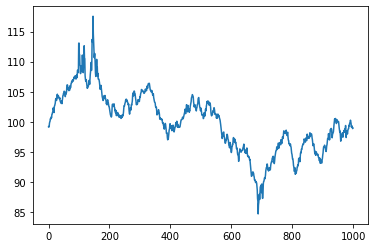

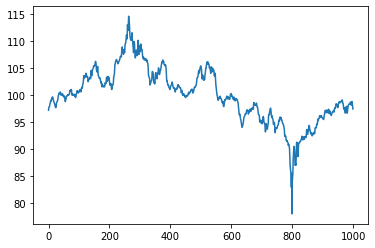

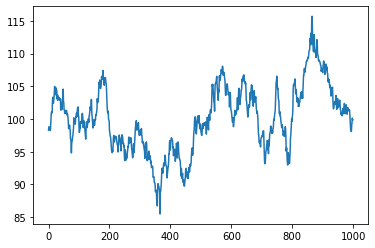

In [45]:
psdmodel = PLaw
psd = (1.,2.,0.)
pdfmodel = st.norm
pdf = (100,5.)
tbin = 1.
lc_len = 1000
size = 3
keep_OGLC = 'y'

delc = Simulate_DE_Lightcurve(PSDmodel = psdmodel, PSDparams = psd,PDFmodel = pdfmodel,\
                              PDFparams = pdf, tbin = tbin, LClength = lc_len, size = size)#, maxFlux = 1000)
for i in range(0,size):
    plt.errorbar(delc[i].time,delc[i].flux, delc[i].errors)
    plt.show()
    plt.close()

e_splice = np.random.normal(loc = 2, scale = 0.5, size = len(t_splice))

if size > 2:
    t_splice = delc[0].time
    f_splice = delc[0].flux
    
    for j in range(0,len(delc)):
        t_splice = np.concatenate((t_splice,delc[j].time))
        f_splice = np.concatenate((f_splice,delc[j].flux))
        e_splice = np.concatenate((e_splice,Simulate_Errors(e_splice,len(delc[j].time))))
        
else:
    t_splice = delc.time
    f_splice = delc.flux
          
delc = Lightcurve(t_splice,f_splice,tbin,errors=e_splice)